# Exploration of Twitter attitudes toward Presidental Candidates
- used tweepy library to scrape data & output json file
- filtered the listener stream based on keywords: 'trump','cruz','kasich','rubio', 'carson','clinton','sanders' 

In [16]:
import json
import numpy as np
import tweetExplore_fns as fns
import importlib
import matplotlib
import matplotlib.pyplot as plt
from textblob import TextBlob
from matplotlib import gridspec
import seaborn as sns
import pandas as pd

sns.set_context("talk")
sns.set_style('darkgrid')

importlib.reload(fns);
%matplotlib inline

### *Initial Organization of the Data*

In [3]:
#  import data 
with open('../data/raw_tweets1_5hr_candidates.json') as data_file:
    rawdata = json.load(data_file)

# selects only tweets that have text 
tweet_list = fns.extract_tweets(rawdata)
        
#  extract indices for tweets that also have a fields of interest
coord_index_list = fns.extract_indices(tweet_list,"coordinates")

# extract tweets that also have a gps coordinate 
coord_tweet_list = fns.extract_tweets_fieldOfInterest(tweet_list,"coordinates")

print('N Tweets', len(tweet_list),'N coordinates:',len(coord_index_list))

N Tweets 189042 N coordinates: 129



- Have a decent number of tweets scraping for 90 minutes! 
- But there are too few GPS coordinates to really do anything interesting :-( 


## *Sentiment Analysis*

- Are the tweets about each candidate positive or negative? 
- But first, are some candidates getting tweeted about more than others? 

#### Total Number of Tweets per Candidate
- count and plot the total number of tweets per candidate
- extract the sentiment score for each tweet

In [4]:
candidates = ['Trump','Cruz','Kasich','Rubio','Carson','Clinton','Sanders'] #track list

# for each candidate
tweet_index_store = []
subjectivity_store = []
polarity_store = []
for iperson,val in enumerate(candidates):
    # save each candidate's list of polarity etc. in a list 
    person_sentiment_polarity, person_sentiment_subjectivity, person_tweetInd = \
    fns.extract_sentiment(tweet_list,candidates[iperson])
    # store tweet polarity (sentiment pos/neg) for each candidate
    polarity_store.append(person_sentiment_polarity)
    # store tweet subjectivity for each candidate
    subjectivity_store.append(person_sentiment_subjectivity)
    # store indices for tweets about each candidate
    tweet_index_store.append(person_tweetInd)

Trump   # tweets: 110392
Cruz   # tweets: 18673
Kasich   # tweets: 1601
Rubio   # tweets: 42703
Carson   # tweets: 2608
Clinton   # tweets: 9846
Sanders   # tweets: 7256


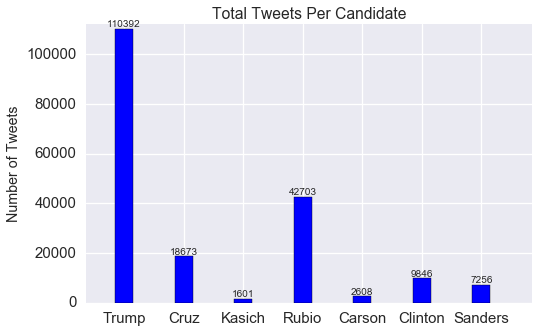

In [5]:
candidate_tweets = []

# for each candidate, get counts of: 
# tweets, positive tweets, negative tweets,
# average positive sentiment, average negative sentiment
for iperson,candidate in enumerate(candidates):
    candidate_tweets.append(len(tweet_index_store[iperson])) # number tweets total
    
# function to label the bars with their value
def autolabelInt(rects):
    """attach labels to bars, integers"""
    for rect in rects:
        height = rect.get_height();
        plt.text(rect.get_x() + rect.get_width()/2., height+.03,
                '%d' % int(height),
                ha='center', va='bottom');

# Plot the total number of tweets per candidate
fig = plt.figure(figsize=(8,5));
matplotlib.rc('xtick',labelsize = 15)
matplotlib.rc('ytick',labelsize = 15)
ymax = np.max(candidate_tweets) + 2000
width = .3

ind = np.arange(len(candidates))+1
rect1 = plt.bar(ind, candidate_tweets, width, color = 'blue')

plt.title("Total Tweets Per Candidate")
plt.xlim([.5,8])
plt.ylim([0,ymax])
plt.ylabel('Number of Tweets')
plt.xticks(ind + width/2, candidates)
autolabelInt(rect1);

### Positive vs. Negative Tweets
- count the number of positive and negative tweets per candidate
- store the avgerage sentiment score for each candidate

In [6]:
# sort tweets into positive/negative lists for each candidate 

store_pos_polarity = []
store_ind_pos_polarity = []
store_tweet_pos_polarity = []
store_neg_polarity = []
store_ind_neg_polarity = []
store_tweet_neg_polarity = []
pos_neg_ratio = []
pos_tweets = []
neg_tweets = []
avg_pos = []
avg_neg = []

# for each candidate
for iperson,val in enumerate(candidates):
    # sort each sentiment score into positive or negative sentiment categories, outputs are:
    # lists of each pos. and neg. sentiment score: pos_polarity, neg_polarity
    # lists of the indices for each tweet w. a pos/neg score: ind_pos_polarity, ind_neg_polarity
    # lists of the texts for each tweet that has a pos/neg tscore: 
                                        #tweet_pos_polarity, tweet_neg_polarity
    pos_polarity, neg_polarity, ind_pos_polarity, ind_neg_polarity, \
    tweet_pos_polarity, tweet_neg_polarity = \
    fns.sortTweetsPosNeg(iperson, polarity_store, tweet_index_store, tweet_list)
    
    # store each candidates lists in a master list
    store_pos_polarity.append(pos_polarity)             # positive sentiment scores
    store_ind_pos_polarity.append(ind_pos_polarity)     # indices of tweets w. pos. scores
    store_tweet_pos_polarity.append(tweet_pos_polarity) # positive tweet texts
    store_neg_polarity.append(neg_polarity)             # negative sentiment scores
    store_ind_neg_polarity.append(ind_neg_polarity)     # indices of tweets w. neg. scores 
    store_tweet_neg_polarity.append(tweet_neg_polarity) # negative tweet texts
    
    # get the ratio of positive to negative tweets
    pos_neg_ratio.append(len(ind_pos_polarity)/len(ind_neg_polarity))
    
    # get counts of # of pos/neg tweets, and the average pos/neg sentiment scores
    pos_tweets.append(len(ind_pos_polarity)) # number positive tweets
    neg_tweets.append(len(ind_neg_polarity)) # number negative tweets
    avg_pos.append(np.average(pos_polarity)) # avg positive tweet sentiment score
    avg_neg.append(np.average(neg_polarity)) # avg negative tweet sentiment score
    
    # print number of positive/negative tweets per person, 
    # and their average positive/negative sentiment score
    print(candidates[iperson],'# Tweets: Positive',len(ind_pos_polarity),
          'Negative',len(ind_neg_polarity), ' Avg. Sentiment: Positive %.2f' \
          % np.average(pos_polarity),'Negative %.2f' % np.average(neg_polarity))


Trump # Tweets: Positive 37515 Negative 21795  Avg. Sentiment: Positive 0.35 Negative -0.30
Cruz # Tweets: Positive 7248 Negative 3368  Avg. Sentiment: Positive 0.34 Negative -0.29
Kasich # Tweets: Positive 638 Negative 296  Avg. Sentiment: Positive 0.37 Negative -0.23
Rubio # Tweets: Positive 14692 Negative 11474  Avg. Sentiment: Positive 0.32 Negative -0.25
Carson # Tweets: Positive 885 Negative 413  Avg. Sentiment: Positive 0.39 Negative -0.25
Clinton # Tweets: Positive 3577 Negative 1792  Avg. Sentiment: Positive 0.35 Negative -0.24
Sanders # Tweets: Positive 2184 Negative 1333  Avg. Sentiment: Positive 0.32 Negative -0.26


#### Positive and Negative Tweets per Candidate
- plot the number of positive and negative tweets per candidate
- plot the ratio of positive/negative tweets for each candidate

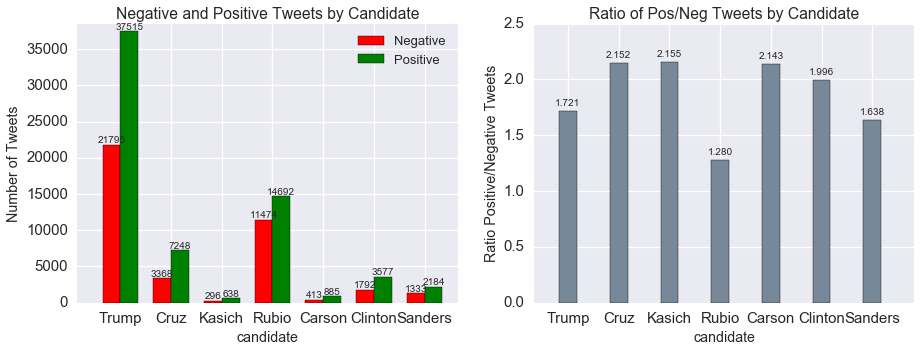

In [7]:
# initial variables for both graphs
width = 0.35       # the width of the bars
ind = np.arange(len(candidates))+1 # shift x location by 1 
ax = [0,1]

# set up figure + subplots
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax[0] = plt.subplot(gs[0])

# plot data for # positive or negative tweets
rectsNeg= ax[0].bar(ind, neg_tweets, width, color='r') 
rectsPos = ax[0].bar(ind + width, pos_tweets, width, color='g')

# set up axes
ymax = np.max([neg_tweets,pos_tweets]) + 1000 # get upper bound for graph
ax[0].set_xlim([.5,8])
ax[0].set_ylim([0,ymax])
ax[0].set_xticks(ind+width)

# add text for labels, title, legend
ax[0].set_title('Negative and Positive Tweets by Candidate')
ax[0].legend((rectsNeg[0], rectsPos[0]), ('Negative', 'Positive'))
ax[0].set_xlabel("candidate")
ax[0].set_ylabel("Number of Tweets")
ax[0].set_xticklabels(candidates)

# label bars with y value, integer
fns.autolabelInt(rectsNeg,ax,0,neg_tweets)
fns.autolabelInt(rectsPos,ax,0,pos_tweets)

# plot second graph - ratio of positive/negative tweets 
ax[1] = plt.subplot(gs[1])
rectRatio = ax[1].bar(ind, pos_neg_ratio, width, color = 'lightslategray') 
# set up axes
ax[1].set_xticks(ind+width/2)
ax[1].set_xlim([.5,8])

# add text for labels, title, legend
ax[1].set_title('Ratio of Pos/Neg Tweets by Candidate')
ax[1].set_xlabel("candidate")
ax[1].set_ylabel("Ratio Positive/Negative Tweets")
ax[1].set_xticklabels(candidates) #rotation = 30

# label y value of bars, decimal 
fns.autolabelDec(rectRatio,ax,1,pos_neg_ratio)
plt.show();

- Here we can see that all candidates have more tweets with positive sentiment scores than negative scores. 
- However, the ratio of positive to negative tweets varies across candidates.
- It is interesting that the three GOP candidates with the fewest overall tweets have the better pos/negative ratios 
- This just looks at binary categorization with sentiment values of 0< or >0. The distribution of sentiment scores for each candidate could differ depending on how enthusiastic their supporters or adversaries are. 
- How positive are the positive tweets for each candidate? How negative are the negative?  

#### Degree of Sentiment

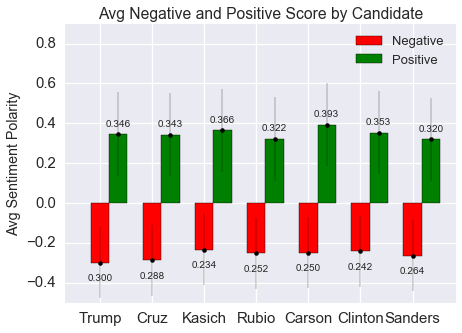

In [8]:

std_pos = []
std_neg = []
sterr_pos = []
sterr_neg = []
for icand, candidate in enumerate(candidates):
    # get standard deviation and standard error for the pos/neg scores for each candidate
    std_pos.append(np.std(store_pos_polarity[iperson]))
    std_neg.append(np.std(store_neg_polarity[iperson]))
    sterr_pos.append(np.std(store_pos_polarity[iperson])/
                     np.sqrt(len(store_pos_polarity[iperson])))
    sterr_neg.append(np.std(store_neg_polarity[iperson])/
                     np.sqrt(len(store_neg_polarity[iperson])))

# set up figure
ind = np.arange(len(candidates))+1 # shift x one
width = 0.35       # the width of the bars
fig = plt.figure(figsize=(7, 5)) 

# set up axes
plt.xticks(ind+width/2,candidates)
plt.xlim([.5,8])
plt.ylim([-.5,.9])

# plot avg positive/negative scores
rectsNeg = plt.bar(ind, avg_neg, width, color='r') #, yerr=menStd
rectsPos = plt.bar(ind + width, avg_pos, width, color='g') #, yerr=womenStd

# plot standard deviation errorbars
plt.errorbar(ind+width/2,avg_neg, yerr=std_neg,fmt='.', color = 'k', elinewidth = .3)
plt.errorbar(ind+width*1.5,avg_pos, yerr=std_pos,fmt='.',color = 'k', elinewidth = .3)

# add some text for labels, title and axes
plt.title('Avg Negative and Positive Score by Candidate')
plt.legend((rectsNeg[0], rectsPos[0]), ('Negative', 'Positive'))
# plt.xlabel("candidate")
plt.ylabel("Avg Sentiment Polarity")

# label bars with y value, decimal 
def autolabelDec(rects,vals):
    """attach labels to bars, 3 decimals"""
    i = 0
    for rect in rects:        
        height = rect.get_height()
        if vals[i] > 0:
            plt.text(rect.get_x() + rect.get_width()/2., height+.03,
                '%0.3f' % height,
                ha='center', va='bottom')
        else:
            plt.text(rect.get_x() + rect.get_width()/2., -1*(height+.1),
                '%0.3f' % height,
                ha='center', va='bottom')
        i = i+1

autolabelDec(rectsNeg,avg_neg)
autolabelDec(rectsPos,avg_pos)

plt.show();


- This visualization doesn't seem to show much of a difference between the candiates. 
- Perhaps looking at the distribution rather than the average would better represent the data 

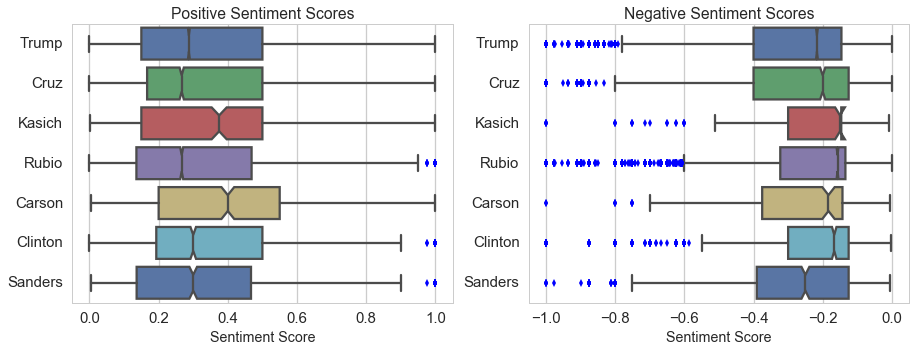

In [9]:
ax = [0,1]
sns.set_style("whitegrid")

# Box and Whisker plots for the positive sentiment ratings 

# set up figure + subplots
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax[0] = plt.subplot(gs[0])

# plot positive scores
ax[0] = sns.boxplot(data = store_pos_polarity, orient = "h", palette = "deep", notch = 1)
# ax[0] = sns.violinplot(data = store_pos_polarity, orient = "h", palette = "deep", notch = 1)

# set up axes/labels
ax[0].set_xlim([-.05,1.05])
ax[0].set_title('Positive Sentiment Scores');
ax[0].set_xlabel('Sentiment Score')
ax[0].set_yticklabels(candidates);


# Box and Whisker plots for the negative sentiment ratings 
ax[1] = plt.subplot(gs[1])

# plot negative scores
ax[1] = sns.boxplot(data = store_neg_polarity, orient = "h", palette = "deep", notch = 1)
# ax[1] = sns.violinplot(data = store_neg_polarity, orient = "h", palette = "deep")

# set up axes/labels
ax[1].set_xlim([-1.05,.05])
ax[1].set_xlabel('Sentiment Score')
ax[1].set_title('Negative Sentiment Scores');
ax[1].set_yticklabels(candidates);


- Now we can extract a little more information about the distribution of sentiment scores
- There doesn't seem to be a great amount of variability among the positive tweets for each candidate, other than Kasich and Carson's median tweet scores are higher than the other candidates. 
- The negative tweets show a bit more variability in their sentiment scores. 
- Kasich interestingly has the least negative distribution, with only a handful of tweets falling as outliers (greater than 1.5 interquartile range from the lower quartile)
- While having very few tweets, Kasich has the best Positive/Negative Tweet ratio, one of the higher positive sentiment medians, and the least negative distribution from the negative tweets in this dataset
- Rubio also seems to have a distribution that is skewed toward 0, resulting in many tweets judged as outliers

### Are these measures representative of other rankings?

#### Correlation of Sentiment with Other Ratings
- correlation of positive/negative sentiment ratio with Favorable/Unfavorable scores from Real Clear Politics

#### Correlation of Number of Tweets with Support 
- correlation of percent tweets in dataset mentioning a specific candidate, and the average polls reported on 538

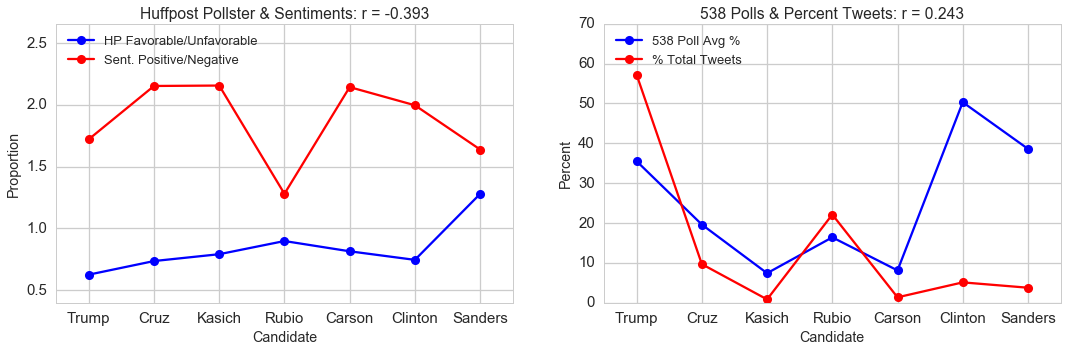

In [13]:
# favorable & unfavorable scores
# ['Trump','Cruz','Kasich','Rubio','Carson','Clinton','Sanders'] (reminder of order)
# from Huffpost Pollster 2/26/16
hp_favorable = np.array([36.1, 34.7, 25.9, 36.3, 36.7, 40.0, 49.0]) 
# from Huffpost Pollster 2/26/16
hp_unfavorable = np.array([57.6, 47.1, 32.7, 40.4, 45.0, 53.6, 38.3]) 

# ratio favorable / unfavorable poll
fav_unfav_ratio = hp_favorable/hp_unfavorable

# pearson corrleation between favorable/unfavorable and positive/negative ratios
hp_pearson_corr = np.corrcoef(fav_unfav_ratio, pos_neg_ratio)

# 538 Polling averages from 2/26/16 
# ['Trump','Cruz','Kasich','Rubio','Carson','Clinton','Sanders'] (reminder of order)
avg_538 = [35.5, 19.6, 7.4, 16.4, 8.1, 50.3, 38.6]

# pearson correlation between 538 average poll 
# and % of tweets in dataset mentioning each candidate 
num_tweet_array = np.array(candidate_tweets)
proportion_tweets = (num_tweet_array/num_tweet_array.sum())*100
numTweets_538_pearson_corr = np.corrcoef(avg_538,proportion_tweets)


# Plot the correlations:
ind = np.arange(len(candidates))+1 # shift x one
ax = [0,1]
fig = plt.figure(figsize=(18, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax[0] = plt.subplot(gs[0])

# set up axes
ymax = np.max([pos_neg_ratio,fav_unfav_ratio]) + .5
ax[0].set_xticks(ind)
ax[0].set_ylim([.4,ymax])
ax[0].set_xlim([.5,len(candidates)+.5])

# plot ratios for Huffpost Pollster 
lineFav = ax[0].plot(ind,fav_unfav_ratio,c='b',marker = 'o')
linePos = ax[0].plot(ind,pos_neg_ratio,c='r',marker='o')

# labels
ax[0].set_xticklabels(candidates)
ax[0].set_title('Huffpost Pollster & Sentiments: r = %0.3f' % hp_pearson_corr[0][1])
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("Candidate")
ax[0].legend((lineFav[0], linePos[0]), ('HP Favorable/Unfavorable', \
                                        'Sent. Positive/Negative'),loc = 2)

# plot ratios for 538
ax[1] = plt.subplot(gs[1])
line538 = ax[1].plot(ind,avg_538,c='b',marker = 'o')
lineProp = ax[1].plot(ind,proportion_tweets,c='r',marker='o')

# set up axes
ax[1].set_xticks(ind)
ax[1].set_xlim(.5,len(candidates)+.5)

# labels
ax[1].legend((line538[0], lineProp[0]), ('538 Poll Avg %', '% Total Tweets'),loc = 2)
ax[1].set_xticklabels(candidates)
ax[1].set_ylim([0,70])
ax[1].set_title('538 Polls & Percent Tweets: r = %0.3f' % numTweets_538_pearson_corr[0][1])
ax[1].set_ylabel("Percent")
ax[1].set_xlabel("Candidate")
plt.show;


- There seems to be a medium sized negative correlation between the ratio of Favorable/Unfavorable ratings and number of Positive/Negative tweets
- There is a smaller positive between the 538 polls and the % of tweets in this dataset mentioning each candidate
- Looking at the data however, it seems like the Democrats may be throwing off the correlation, what if we just correlate the GOP candidates?

#### Correlation of 538 Avg Polls and % Number of Tweets per Candidate - GOP only

In [14]:
rep_numTweets_538_pearson_corr = np.corrcoef(avg_538[:5],candidate_tweets[:5])
print('GOP only correlation coefficient between 538 Avg Polls and Number of Tweets: %0.3f' \
      % rep_numTweets_538_pearson_corr[0][1])


GOP only correlation coefficient between 538 Avg Polls and Number of Tweets: 0.949


- With a high correlation of r = .949, it seems as though the average polling data from 538 tracks well with the percent of tweets about each candidate (p = 0.014)
- Perhaps the % of tweets for each Republican candidate each day could predict changes in poll outcomes! 

## Who has a rival?
- I've investigated the the tweets based on a single mention of a candidate. However, more than one candidate is often mentioned in the same tweet. 
- Tweets mentioning two candidates often pit one against each other. If we assume that two candidates mentioned in the same tweet are being contrasted against each other, then which candidates have a 'rival' to which they are often compared? 

In [17]:
rival_index_store = []
rival_count_store = []

# for each candidate
for iperson,val in enumerate(candidates):
    current_inds = tweet_index_store[iperson]
    # remove current candidate from list, so cannot be own rival
    rival_list_temp = np.arange(len(candidates)) 
    mask_self = np.ones(rival_list_temp.shape,dtype=bool)
    mask_self[iperson] = 0
    rival_list = rival_list_temp[mask_self]
    [rival_index_temp, count] = fns.rival_count(rival_list,current_inds, candidates, tweet_list)
    rival_count_store.append(count)
    rival_index_store.append(rival_index_temp)
    print(val,count)

Trump [0, 6336, 647, 17940, 515, 1426, 672]
Cruz [6336, 0, 585, 6346, 456, 229, 130]
Kasich [647, 585, 0, 651, 411, 17, 11]
Rubio [17940, 6346, 651, 0, 451, 283, 150]
Carson [515, 456, 411, 451, 0, 6, 14]
Clinton [1426, 229, 17, 283, 6, 0, 1367]
Sanders [672, 130, 11, 150, 14, 1367, 0]


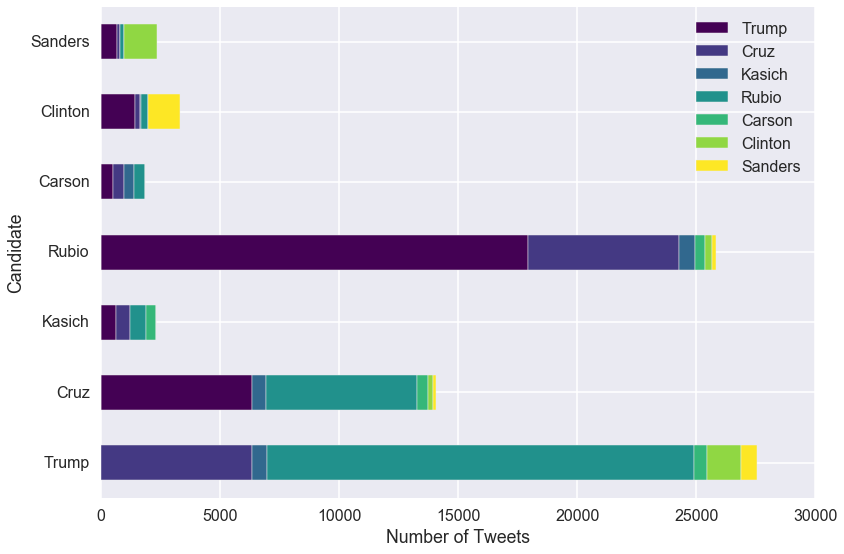

In [21]:
# plot the proportion of tweets with a second candidate mentioned - for each candidate
sns.set_context('poster')
sns.set_style('darkgrid')
x = np.arange(len(candidates))
# plt.stackplot(x,np.array(rival_count_store))
df2 = pd.DataFrame(rival_count_store, columns=candidates)
df2.plot(kind='barh', stacked=True, colormap='viridis')
plt.yticks(x, candidates)
plt.xlabel('Number of Tweets')
plt.ylabel('Candidate');

- It definitely seems like some candidates are mentioned together a disproportionate amount. But who is the #1 Rival for each candidate? 
- It is interesting that the GOP candidates receiving the least attention (# tweets overall) have a more even distribution of mentions with other candidates than the candidates who are receiving more attention 

#### Find the top rival for each candidate
- For each candidate, which other candidate is mentioned in the same tweet most frequently?

In [19]:
maxRival = []
maxRival_ind = []
storeRivalTweets = []

for icand, cand in enumerate(candidates):
    # get list of all candidates except current one
    rival_list_temp = np.arange(len(candidates)) 
    mask_self = np.ones(rival_list_temp.shape,dtype=bool)
    mask_self[icand] = 0
    rival_array = rival_list_temp[mask_self]
    rival_list = rival_array.tolist()
    
    # get max count index of simultaneous mentions to select top rival 
    cur_maxRival_ind = np.argmax(rival_count_store[icand])
    # store index of max rival 
    maxRival_ind.append(cur_maxRival_ind)
    # store rival name 
    maxRival.append(candidates[cur_maxRival_ind])

    # index of rival from rival only list
    rival_only_ind = rival_list.index(cur_maxRival_ind)
    # store tweets with rival 
    storeRivalTweets.append(rival_index_store[icand][rival_only_ind])
    print(cand,"'s top rival is:",candidates[cur_maxRival_ind])

Trump 's top rival is: Rubio
Cruz 's top rival is: Rubio
Kasich 's top rival is: Rubio
Rubio 's top rival is: Trump
Carson 's top rival is: Trump
Clinton 's top rival is: Trump
Sanders 's top rival is: Clinton


- Based on this measure, Trump and Rubio are the primary candidates who are contrasted against the other candidates. 
- Clinton is mentioned most often in the same tweet as Trump, whereas Sanders' rival is Clinton

# Future Directions
- Can we predict polling data based on the percentage of tweets going to each GOP candidate? 
- The sentiment analysis I'm using at the moment is a 'black box'. I'd like to train my own classifier and see how performance changes.
- I could use NLTK to do a topic analysis (TF-IDF) to see if the important issues for each candidate are different 
- If I scrape data during a high-profile event, like a debate, I'm likely to get more than one tweet per user. For each user, I can define a 'preferred candidate' based on the number of positive tweet mentions, and a 'secondary candidate' as the second favorite, based on other positive tweets, or the fewest number of highly negative tweets. Then, I could predict if different GOP candidates drop out of the race, how many tweets by that user and other users are likely to shift toward supporting a different candidate. Using % tweets as a proxy for polling data, I could see if I can predict shifts in polls after a candidate drops out.
- I could reuse this code to help me decide where to pursue a job opportunity. I could scrape twitter with different health tech company names, and then correlate the proportion of positive tweets for each company with ratings on glassdoor. If they agree, the results might affect my actions!